# Projekt Voki: vocabulary cards extraction

## Imports

In [94]:
import json
import fitz
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
import numpy as np
import pandas as pd

%matplotlib inline

## Functions

In [7]:
def myimshow(im,h=12,w=8):
    plt.figure(figsize=(w,h))
    plt.imshow(im)
    plt.show()
    
def gridshow(imgs,h=12,w=8):
    n=len(imgs)    
    fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
    for j, ax in enumerate(axes):
        ax.imshow(plot_images[j])
        ax.set_xticks([])
        ax.set_yticks([])
    
def getpage(data,n):
    if n<0:
        raise Exception(f'n ({n}) must be 0 or larger')
    if n< len(data['analyze_result']['read_results']): 
        return data['analyze_result']['read_results'][n]
    else: raise Exception(f"n ({n}) must be smaller than the number of pages ({len(data['analyze_result']['read_results'])})")
    
def box_to_polygon(box,w_inch,h_inch,w_pix,h_pix):
    box = np.array(box)
    return np.array([[int(x),int(y)] for x,y, in zip(box[::2]/w_inch*w_pix,box[1::2]/h_inch*h_pix)])

## Content
### get pdf and json files

In [3]:
root = Path.cwd()
root

fname_json = root.parent /'data/serievertes2.json'
fname_pdf = root.parent /'data/Scan_01-12-2021_1728.pdf' 

with open(fname_json,'r') as fh:
    data_raw=json.load(fh)

image_list=[]
zoom = 2 # to increase the resolution
mat = fitz.Matrix(zoom, zoom)
doc = fitz.open(fname_pdf)
for page in doc:
    pix = page.get_pixmap(matrix = mat)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    image_list.append(img)
 

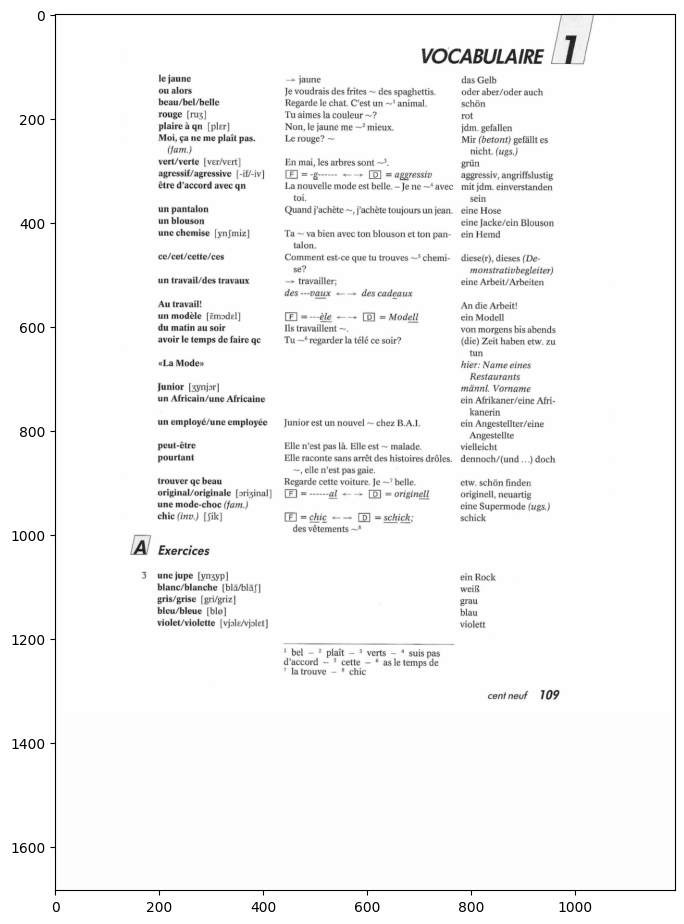

In [11]:
# show an example
myimshow(image_list[0])

### create images with poxes for visualization purpose

In [68]:

results=[]
for i, image in enumerate(image_list):
    data = getpage(data_raw,i)
    w_inch=data['width']
    h_inch=data['height']
    im=deepcopy(image)
    im = np.array(im) 
    im = im[:, :, ::-1].copy()
    h_pix ,w_pix,_ = im.shape
    line_polygons=[]
    word_polygons=[]
    
    for line in data['lines']:
        # add line info
        line_polygon = box_to_polygon(line['bounding_box'],w_inch,h_inch,w_pix,h_pix)
        im=cv2.polylines(im, [line_polygon], True, (0,255,0), thickness=3)
        line_polygons.append(line_polygon)

        # add word info
        # for word in line['words']:
        #     word_polygon = box_to_polygon(word['bounding_box'],w_inch,h_inch,w_pix,h_pix)
        #     im=cv2.polylines(im, [word_polygon], True, (255,0,0), thickness=2)
        #     word_polygons.append(word_polygon)
            
    page_result= {
        'im':im,
        'im_raw':deepcopy(image),
        'w_inch':w_inch,
        'h_inch':h_inch,
        'h_pix':h_pix,
        'w_pix':w_pix,
        'line_polygons':line_polygons,
        'word_polygons':word_polygons
        
    }
    results.append(page_result)
    

### plot those pages

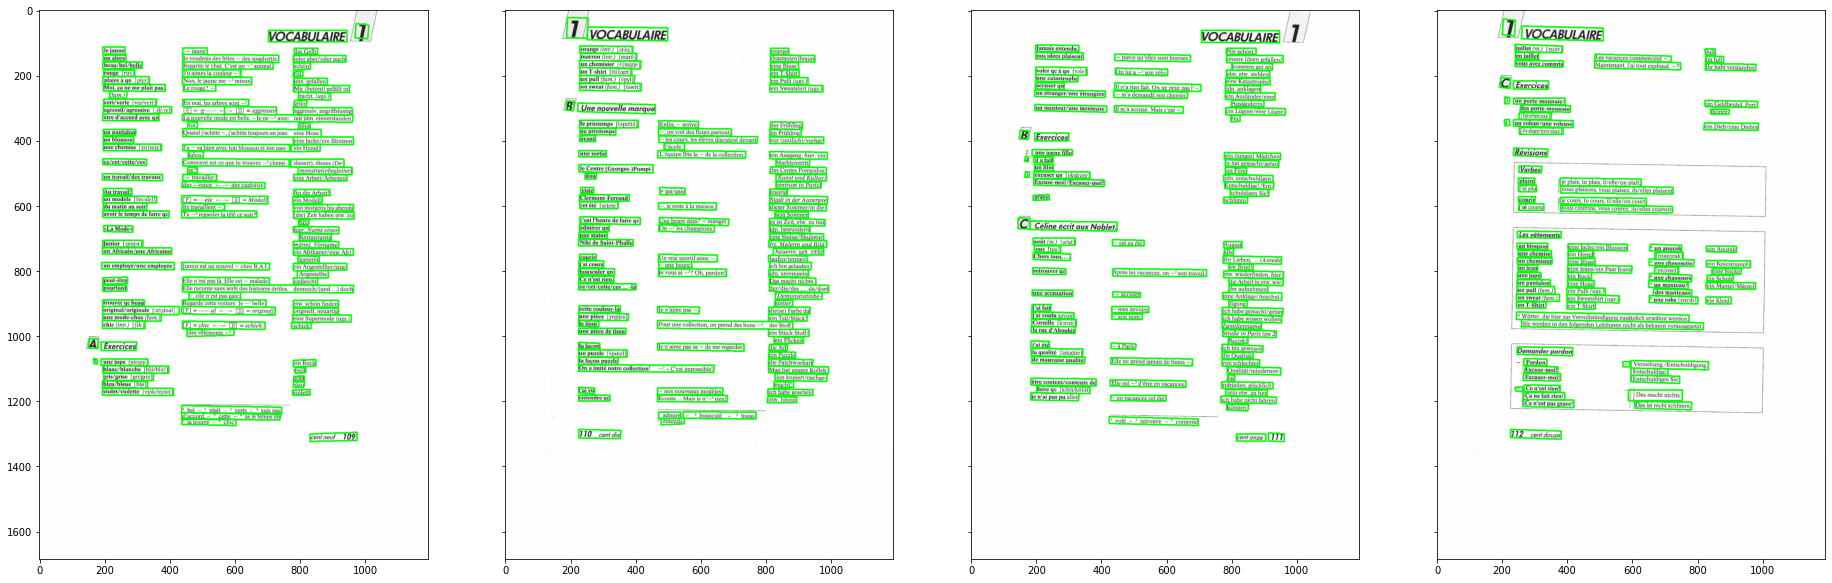

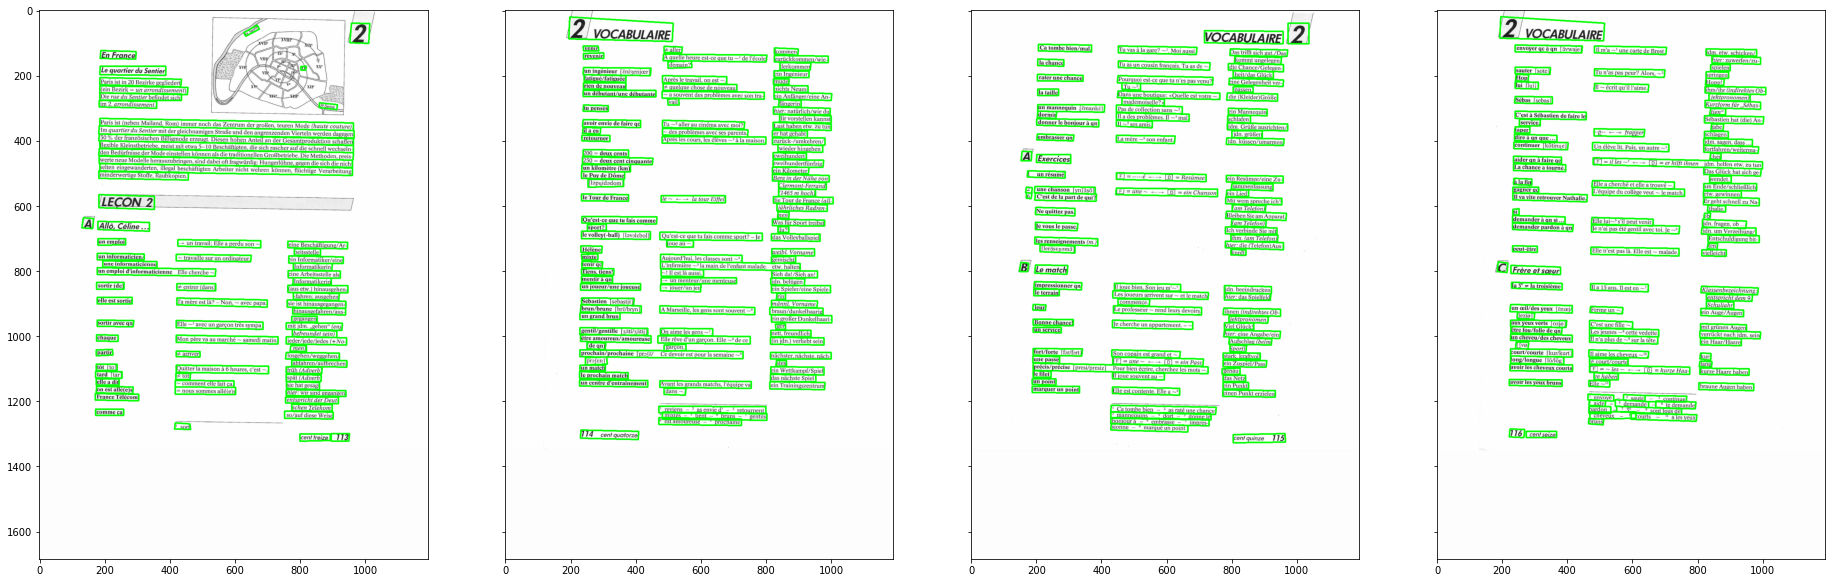

In [69]:
plot_images=[10]
n = 4# number of images in one row
h = 8
plot_images=[]
for i,result in enumerate(results[:10]):
    
    plot_images.append(result['im'])
    if i%n == n-1:
        fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
        for j, ax in enumerate(axes):
            
            ax.imshow(plot_images[j])
        plot_images=[]
        
        
    

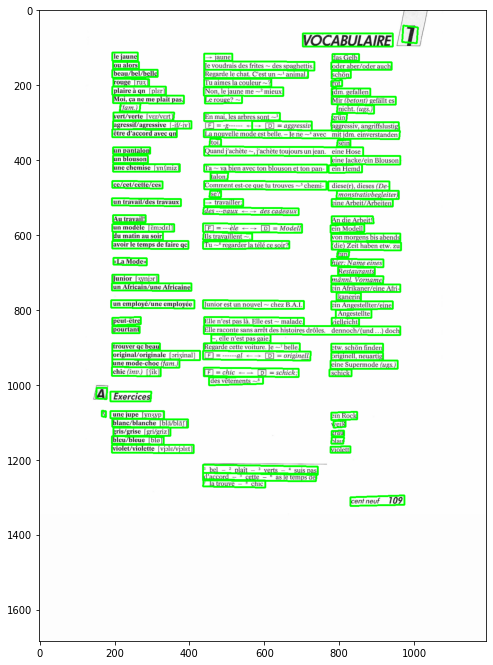

In [70]:
myimshow(results[0]['im'])

## figure out page column parameters

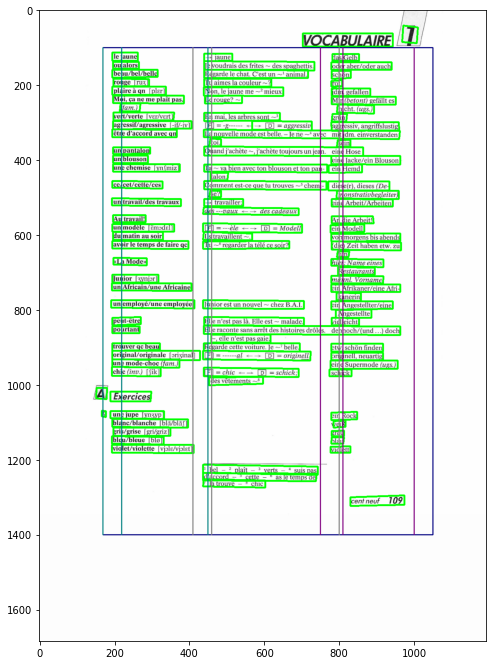

In [71]:
i=0
im = deepcopy(results[i]['im'])
page_height,page_width,n_channels = im.shape
line_thickness = 2

props = {'left': 
         {'x':[170,220,450],
          'col':(0, 128, 128)},
         'right':
         {'x':[750,810,1000],
          'col':(128, 0, 128)},
         'center':
         {'x':[410,460,800],
          'col':(128, 128, 128)}
        }

canvas_start = (170,100)
canvas_end = (1050,1400)
canvas_color = (0,0,128)

im = cv2.rectangle(im, canvas_start, canvas_end, canvas_color, line_thickness)

for prop,vals in props.items():
    for x in vals['x']:
        im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), vals['col'], thickness=line_thickness)
    
myimshow(im)

In [ ]:
def page_data_to_df(data)

In [112]:

for i, image in enumerate(image_list[:1]):
    # get data for one page
    data = getpage(data_raw,i)
    w_inch=data['width']
    h_inch=data['height']
    im=deepcopy(image)
    im = np.array(im) 
    im = im[:, :, ::-1].copy()
    h_pix ,w_pix,_ = im.shape
    
    dfs = []
    # go through all lines and record the coordinates
    for j,line in enumerate(data['lines']):
        df_dict = {}
        box_points = box_to_polygon(line['bounding_box'],w_inch,h_inch,w_pix,h_pix)
        
        df_dict = {'text': [line['text']],
                   'x_min' : [np.min(box_points[:,0])],
                   'x_max': [np.max(box_points[:,0])],
                   'y_min': [np.min(box_points[:,1])],
                   'y_max': [np.max(box_points[:,1])],
                   'confidence': [line['appearance']['style']['confidence']],
                   'word_texts': [[word['text'] for word in line['words']]],
                   'word_confidences': [[word['confidence'] for word in line['words']]],
                   
                   'page': data['page'],
                   'page_angle': data['angle'], 
                   'page': data['page'],
                   }
        dfs.append(pd.DataFrame(df_dict))
        
        
df = pd.concat(dfs)
df
    


,text,x_min,x_max,y_min,y_max,confidence,word_texts,word_confidences,page,page_angle
0,VOCABULAIRE,703,943,62,97,0.878,[VOCABULAIRE],[0.994],1,0.0
0,1,968,1010,41,88,0.586,[1],[0.367],1,0.0
0,le jaune,195,263,113,135,0.878,"[le, jaune]","[0.996, 0.996]",1,0.0
0,- jaune,440,515,116,136,0.878,"[-, jaune]","[0.979, 0.996]",1,0.0
0,das Gelb,782,853,117,135,0.878,"[das, Gelb]","[0.994, 0.994]",1,0.0
...,...,...,...,...,...,...,...,...,...,...
0,violett,777,830,1164,1181,0.878,[violett],[0.994],1,0.0
0,1 bel - 2 plaît - > verts - 4 suis pas,437,743,1213,1240,0.878,"[1, bel, -, 2, plaît, -, >, verts, -, 4, suis,...","[0.869, 0.997, 0.994, 0.966, 0.78, 0.994, 0.04...",1,0.0
0,d'accord - 5 cette - 6 as le temps de,437,740,1235,1257,0.878,"[d'accord, -, 5, cette, -, 6, as, le, temps, de]","[0.986, 0.994, 0.961, 0.995, 0.958, 0.789, 0.9...",1,0.0
0,la trouve - 8 chic,437,603,1252,1274,0.878,"[la, trouve, -, 8, chic]","[0.821, 0.996, 0.995, 0.453, 0.987]",1,0.0


In [110]:
df_dict

{'text': ['le jaune'],
 'x_min': [195],
 'x_max': [263],
 'y_min': [113],
 'y_max': [135],
 'confidence': [0.878],
 'word_texts': ['le', 'jaune'],
 'word_confidences': [0.996, 0.996],
 'page': 1,
 'page_angle': 0.0}

In [86]:
np.min(box_points[:,1])

62

In [101]:
[word['text'] for word in line['words']]
    

['VOCABULAIRE']

In [102]:
[word['confidence'] for word in line['words']]

[0.994]

In [100]:
data

{'page': 1,
 'angle': 0.0,
 'width': 8.2778,
 'height': 11.6944,
 'unit': 'inch',
 'lines': [{'bounding_box': [4.8826,
    0.4311,
    6.5532,
    0.4311,
    6.5532,
    0.679,
    4.8826,
    0.679],
   'appearance': {'style': {'name': 'other', 'confidence': 0.878}},
   'text': 'VOCABULAIRE',
   'words': [{'bounding_box': [4.8934,
      0.4311,
      6.5317,
      0.4419,
      6.5209,
      0.679,
      4.8934,
      0.6898],
     'text': 'VOCABULAIRE',
     'confidence': 0.994}]},
  {'bounding_box': [6.7473,
    0.291,
    7.0167,
    0.3233,
    6.9952,
    0.6144,
    6.7257,
    0.5928],
   'appearance': {'style': {'name': 'other', 'confidence': 0.586}},
   'text': '1',
   'words': [{'bounding_box': [6.7796,
      0.291,
      6.9628,
      0.3018,
      6.9305,
      0.6036,
      6.7473,
      0.5928],
     'text': '1',
     'confidence': 0.367}]},
  {'bounding_box': [1.3581,
    0.7868,
    1.8323,
    0.7868,
    1.8323,
    0.9377,
    1.3581,
    0.9377],
   'appearance': 

In [141]:
[[i,x['angle']] for i,x in enumerate(data_raw['analyze_result']['read_results'])]

[[0, 0.0],
 [1, 0.4035],
 [2, 0.6987],
 [3, 0.6585],
 [4, 0.8127],
 [5, 0.6161],
 [6, 1.1112],
 [7, 1.1573],
 [8, 0.8425],
 [9, 0.786],
 [10, 0.7198],
 [11, 0.5886],
 [12, 0.5876],
 [13, 0.812],
 [14, 0.5048],
 [15, 0.6945],
 [16, 0.434],
 [17, 0.0],
 [18, 0.4213],
 [19, 0.7639],
 [20, 0.2728],
 [21, 0.6094],
 [22, 0.4795],
 [23, 0.2292],
 [24, 0.7252],
 [25, 0.3924],
 [26, 0.7393],
 [27, 0.0],
 [28, 0.5787],
 [29, 0.5305],
 [30, 0.7162],
 [31, 0.1768],
 [32, 0.5907],
 [33, 0.0],
 [34, 0.8029],
 [35, 0.0],
 [36, 0.443],
 [37, 0.4815],
 [38, 0.4547],
 [39, 0.1391],
 [40, 0.3493],
 [41, 0.4774],
 [42, 0.4569],
 [43, 0.2513]]